In [2]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import curve_fit
import pandas as pd

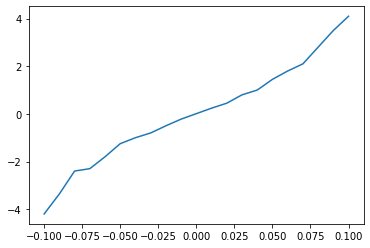

In [16]:
Overpotential = np.linspace(-.1,.1,21)
Overpotential = np.concatenate((Overpotential[0:10],Overpotential[11:]))
Current = [-4.2,-3.36,-2.4,-2.3,-1.8,-1.25,-1,-.8,-.5,-.22,.24,.45,.8,1.,1.45,1.8,2.1,2.8,3.5,4.1]
# Ewe = np.array(data['Ewe/V'])
# Current = np.array(data['<I>/mA'])
# cycles = data['cycle number']
# time = data['time/s']

len(Overpotential), len(Current)
plt.plot(Overpotential, Current)
# plt.plot(Current,Overpotential)

### Testing with 1 cycle:

In [55]:
def BV(overpotential, j0, aa,ac):
    '''
    takes in cell potential [V] + parameters:j0 [A/m^2],aa,ac
    returns current DENSITY [A/m^2]
    '''
    F = 96485.33212 #C/mol
    R = 8.314 #J/mol-K
    T = 298 #K
    z = 1
    
    j = j0*(np.exp(aa*z*F*overpotential*(R*T)**(-1))-np.exp(-ac*z*F*overpotential*(R*T)**(-1)))
    
    return j

In [38]:
def BV_one_minus(overpotential, j0, aa):
    '''
    takes in cell potential [V] + parameters:j0 [A/m^2],aa,ac
    returns current DENSITY [A/m^2]
    '''
    F = 96485.33212 #C/mol
    R = 8.314 #J/mol-K
    T = 298 #K
    z = 1
    
    j = j0*(np.exp(aa*z*F*overpotential*(R*T)**(-1))-np.exp(-(1-aa)*z*F*overpotential*(R*T)**(-1)))
    
    return j

### Testing with 1 guess

j0: 0.5893, aa: 0.5084, ac: 0.5033
errors are this % of values: [7.62305994 4.20826179 4.25893734]


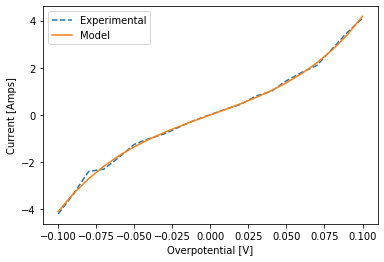

In [56]:
# ans = curve_fit(BV,use_v,use_current_densities,[.5,.5,.5],bounds=([-np.inf,0,0],[np.inf,2,2]),maxfev=4000)
ans = curve_fit(BV,Overpotential,Current,[2,0.001,0.99],maxfev=8000)
j0_fit, aa_fit, ac_fit = ans[0]
print('j0: {:.4f}, aa: {:.4f}, ac: {:.4f}'.format(j0_fit, aa_fit, ac_fit))
pcov = ans[1]
perr = np.sqrt(np.diag(pcov))
# print('errors:',perr)
print('errors are this % of values:',perr/ans[0]*100 )


j_fitted = BV(Overpotential, j0_fit, aa_fit, ac_fit)
plt.plot(Overpotential,Current, '--',label = 'Experimental')
plt.plot(Overpotential,j_fitted, label = 'Model')
plt.xlabel('Overpotential [V]')
plt.ylabel('Current [Amps]')
plt.legend()
plt.show()

j0: 0.6018, aa: 0.5026, ac: 0.4974
errors r this % of values: [1.04389194 0.61981382]


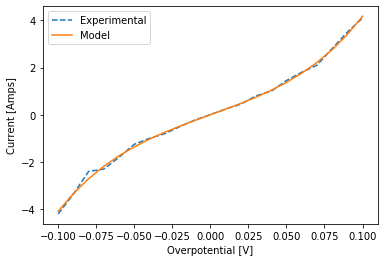

In [57]:
# ans = curve_fit(BV,use_v,use_current_densities,[.5,.5,.5],bounds=([-np.inf,0,0],[np.inf,2,2]),maxfev=4000)
ans = curve_fit(BV_one_minus,Overpotential,Current,[2,0.001],maxfev=8000)
j0_fit, aa_fit = ans[0]
ac_fit = 1-aa_fit
print('j0: {:.4f}, aa: {:.4f}, ac: {:.4f}'.format(j0_fit, aa_fit, 1-aa_fit))
pcov = ans[1]
perr = np.sqrt(np.diag(pcov))
print('errors r this % of values:',perr/ans[0]*100 )


j_fitted = BV_one_minus(Overpotential, j0_fit, aa_fit)
plt.plot(Overpotential,Current, '--',label = 'Experimental')
plt.plot(Overpotential,j_fitted, label = 'Model')
plt.xlabel('Overpotential [V]')
plt.ylabel('Current [Amps]')
plt.legend()
plt.show()

In [58]:
length = 20
# print('Max current is {:.1f} amps\nMin current is {:.1f} amps'.format(max(use_current_densities),min(use_current_densities)))
j0_guesses = np.linspace(min(Current),max(Current),length)
aa0_guesses = np.linspace(0.001,.87,len(j0_guesses))
ac0_guesses = np.linspace(0.003,.9,len(j0_guesses))

#matrix of all combinations of these guesses:
p0s = np.array(np.meshgrid(j0_guesses,aa0_guesses,ac0_guesses)).T.reshape(-1,3)

np.shape(p0s)

(8000, 3)

In [53]:
identified_js = []
identified_aas = []
identified_acs = []

for m in range(len(p0s)):
    try: 
        anss = curve_fit(BV,Overpotential,Current,p0s[m])
#         anss = curve_fit(BV,use_V,use_I,p0s[m],maxfev=8000)
        gs = anss[0] 
        
        alphas_are_positive = gs[1]>0 and gs[2]>0
        j0_not_zero = gs[0]>1e-4
#         j0_not_zero = True
        different_from_guess = abs(gs[0]-p0s[m,0])>1e-2 and abs(gs[1]-p0s[m,1])>1e-3 and abs(gs[2]-p0s[m,2])>1e-3 
#         different_from_guess = gs[0] - p0s[m,0] !=0 and gs[1]-p0s[m,1]!=0  and gs[2]-p0s[m,2]!=0  
        alphas_big = gs[1]>0.1 and gs[2]>0.1
        a_sum = gs[1] + gs[2]
        one_ish = a_sum < 1.2 and a_sum<.8
        
        if alphas_are_positive and j0_not_zero and different_from_guess:
            print('guess:',p0s[m],'\ngenerated:',anss[0],'\nerrors:',np.sqrt(np.diag(anss[1])),'\n')
            identified_js.append(gs[0])
            identified_aas.append(gs[1])
            print('aa: {:.4f}'.format(gs[1]))
            identified_acs.append(gs[2])
            print('ac: {:.4f}'.format(gs[2]))
#             
    except RuntimeError:
        print('runtime error\n')


guess: [-4.20000000e+00  6.41315789e-01  3.00000000e-03] 
generated: [0.58935    0.50844298 0.50328867] 
errors: [0.04492649 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-4.20000000e+00  6.87052632e-01  3.00000000e-03] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492641 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-4.20000000e+00  7.32789474e-01  3.00000000e-03] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492629 0.02139659 0.02143473] 

aa: 0.5084
ac: 0.5033
guess: [-4.20000000e+00  7.78526316e-01  3.00000000e-03] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492651 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-4.20000000e+00  8.24263158e-01  3.00000000e-03] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492649 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-4.2e+00  8.7e-01  3.0e-03] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492649 0.02139661 0.02143475] 

aa: 0.5084


aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.22968421 0.003     ] 
generated: [0.58934993 0.50844301 0.5032887 ] 
errors: [0.04492632 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.27542105 0.003     ] 
generated: [0.58935003 0.50844296 0.50328865] 
errors: [0.0449266  0.02139663 0.02143477] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.32115789 0.003     ] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492644 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.36689474 0.003     ] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492654 0.02139662 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.41263158 0.003     ] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492644 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.45836842 0.003     ] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492644 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.50410526 0.003 

guess: [2.78947368 0.54984211 0.003     ] 
generated: [0.58934997 0.508443   0.50328868] 
errors: [0.04492712 0.02139666 0.0214348 ] 

aa: 0.5084
ac: 0.5033
guess: [2.78947368 0.59557895 0.003     ] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.0449264  0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [2.78947368 0.64131579 0.003     ] 
generated: [0.58935001 0.50844298 0.50328866] 
errors: [0.04492679 0.02139663 0.02143476] 

aa: 0.5084
ac: 0.5033
guess: [2.78947368 0.68705263 0.003     ] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492643 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [2.78947368 0.73278947 0.003     ] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492649 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [2.78947368 0.77852632 0.003     ] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492653 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [2.78947368 0.82426316 0.003     ] 
generated: [0.5

guess: [4.10000000e+00 6.87052632e-01 3.00000000e-03] 
generated: [0.5893498  0.50844306 0.50328877] 
errors: [0.04492537 0.02139651 0.02143464] 

aa: 0.5084
ac: 0.5033
guess: [4.10000000e+00 7.32789474e-01 3.00000000e-03] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492648 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [4.10000000e+00 7.78526316e-01 3.00000000e-03] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492648 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [4.10000000e+00 8.24263158e-01 3.00000000e-03] 
generated: [0.58934992 0.50844302 0.50328871] 
errors: [0.04492632 0.0213966  0.02143473] 

aa: 0.5084
ac: 0.5033
guess: [4.1e+00 8.7e-01 3.0e-03] 
generated: [0.58934977 0.50844308 0.50328878] 
errors: [0.04492551 0.02139651 0.02143463] 

aa: 0.5084
ac: 0.5033
guess: [-4.2         0.50410526  0.05021053] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492643 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-4.2    

ac: 0.5033
guess: [0.16842105 0.36689474 0.05021053] 
generated: [0.58935002 0.50844297 0.50328866] 
errors: [0.04492668 0.02139662 0.02143476] 

aa: 0.5084
ac: 0.5033
guess: [0.16842105 0.41263158 0.05021053] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492648 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [0.16842105 0.45836842 0.05021053] 
generated: [0.58935007 0.50844295 0.50328863] 
errors: [0.04492736 0.02139658 0.02143472] 

aa: 0.5084
ac: 0.5033
guess: [0.16842105 0.50410526 0.05021053] 
generated: [0.58934997 0.508443   0.50328868] 
errors: [0.04492645 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [0.16842105 0.54984211 0.05021053] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492649 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [0.16842105 0.59557895 0.05021053] 
generated: [0.58934989 0.50844303 0.50328872] 
errors: [0.04492615 0.02139658 0.02143471] 

aa: 0.5084
ac: 0.5033
guess: [0.16842105 0.64131579 0.05021053] 
gene

guess: [1.47894737 0.59557895 0.05021053] 
generated: [0.58935005 0.50844295 0.50328864] 
errors: [0.04492658 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.64131579 0.05021053] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492647 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.68705263 0.05021053] 
generated: [0.58935003 0.50844296 0.50328866] 
errors: [0.04492584 0.02139653 0.02143467] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.73278947 0.05021053] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492649 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.77852632 0.05021053] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492649 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.82426316 0.05021053] 
generated: [0.58934995 0.508443   0.50328869] 
errors: [0.04492645 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.87       0.05021053] 
generated: [0.5

guess: [2.78947368 0.87       0.05021053] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492649 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579e+00 1.00000000e-03 5.02105263e-02] 
generated: [0.58934991 0.50844302 0.50328871] 
errors: [0.04492644 0.02139667 0.0214348 ] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.04673684 0.05021053] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.09247368 0.05021053] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.13821053 0.05021053] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.18394737 0.05021053] 
generated: [0.5893499  0.50844303 0.50328871] 
errors: [0.04492652 0.0213967  0.02143483] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.22968421 0.05021053] 
gen

guess: [-4.2         0.50410526  0.09742105] 
generated: [0.58935    0.50844298 0.50328867] 
errors: [0.04492635 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-4.2         0.54984211  0.09742105] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492654 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-4.2         0.59557895  0.09742105] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.0449265  0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-4.2         0.64131579  0.09742105] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-4.2         0.68705263  0.09742105] 
generated: [0.58935003 0.50844297 0.50328865] 
errors: [0.04492678 0.02139662 0.02143476] 

aa: 0.5084
ac: 0.5033
guess: [-4.2         0.73278947  0.09742105] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492649 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-4.2         0.77852632  0.09742

errors: [0.04492649 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [0.60526316 0.001      0.09742105] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492665 0.02139663 0.02143476] 

aa: 0.5084
ac: 0.5033
guess: [0.60526316 0.04673684 0.09742105] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [0.60526316 0.09247368 0.09742105] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492644 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [0.60526316 0.13821053 0.09742105] 
generated: [0.58934988 0.50844303 0.50328873] 
errors: [0.04492625 0.02139665 0.02143478] 

aa: 0.5084
ac: 0.5033
guess: [0.60526316 0.18394737 0.09742105] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [0.60526316 0.22968421 0.09742105] 
generated: [0.58935002 0.50844297 0.50328866] 
errors: [0.04492637 0.02139659 0.02143474] 

aa: 0.5084
ac

generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.91578947 0.32115789 0.09742105] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.91578947 0.36689474 0.09742105] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492641 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [1.91578947 0.41263158 0.09742105] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.91578947 0.45836842 0.09742105] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.91578947 0.50410526 0.09742105] 
generated: [0.5893499  0.50844302 0.50328872] 
errors: [0.04492597 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [1.91578947 0.54984211 0.09742105] 
generated: [0.58935002 0.50844298 0.50328865] 
errors: [0.

guess: [3.22631579 0.22968421 0.09742105] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.27542105 0.09742105] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.32115789 0.09742105] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492644 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.36689474 0.09742105] 
generated: [0.58935001 0.50844298 0.50328866] 
errors: [0.04492645 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.41263158 0.09742105] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.45836842 0.09742105] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492635 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.50410526 0.09742105] 
generated: [0.5

ac: 0.5033
guess: [-4.2         0.87        0.14463158] 
generated: [0.58934996 0.508443   0.50328869] 
errors: [0.04492617 0.02139659 0.02143473] 

aa: 0.5084
ac: 0.5033
guess: [-3.76315789  0.41263158  0.14463158] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-3.76315789  0.45836842  0.14463158] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-3.76315789  0.50410526  0.14463158] 
generated: [0.58934982 0.50844305 0.50328877] 
errors: [0.04492454 0.02139648 0.0214346 ] 

aa: 0.5084
ac: 0.5033
guess: [-3.76315789  0.54984211  0.14463158] 
generated: [0.58934988 0.50844303 0.50328872] 
errors: [0.04492651 0.02139671 0.02143484] 

aa: 0.5084
ac: 0.5033
guess: [-3.76315789  0.59557895  0.14463158] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492641 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-3.76315789  0.641315

guess: [0.60526316 0.04673684 0.14463158] 
generated: [0.5893499  0.50844302 0.50328872] 
errors: [0.04492592 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [0.60526316 0.09247368 0.14463158] 
generated: [0.58934992 0.50844301 0.5032887 ] 
errors: [0.04492628 0.0213966  0.02143473] 

aa: 0.5084
ac: 0.5033
guess: [0.60526316 0.13821053 0.14463158] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492644 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [0.60526316 0.18394737 0.14463158] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492665 0.02139663 0.02143476] 

aa: 0.5084
ac: 0.5033
guess: [0.60526316 0.22968421 0.14463158] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.0449264  0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [0.60526316 0.27542105 0.14463158] 
generated: [0.58934995 0.508443   0.50328869] 
errors: [0.04492647 0.02139662 0.02143476] 

aa: 0.5084
ac: 0.5033
guess: [0.60526316 0.32115789 0.14463158] 
generated: [0.5

guess: [1.91578947 0.59557895 0.14463158] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492638 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [1.91578947 0.64131579 0.14463158] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492648 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.91578947 0.68705263 0.14463158] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492648 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.91578947 0.73278947 0.14463158] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492649 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.91578947 0.77852632 0.14463158] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492654 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.91578947 0.82426316 0.14463158] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492651 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.91578947 0.87       0.14463158] 
generated: [0.5

guess: [3.66315789e+00 1.00000000e-03 1.44631579e-01] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.66315789 0.04673684 0.14463158] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.66315789 0.09247368 0.14463158] 
generated: [0.58934995 0.508443   0.50328869] 
errors: [0.04492641 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [3.66315789 0.13821053 0.14463158] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492644 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.66315789 0.18394737 0.14463158] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.66315789 0.22968421 0.14463158] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.66315789 0.27542105 0.14463158] 
gen

guess: [-3.76315789  0.73278947  0.19184211] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492649 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-3.76315789  0.77852632  0.19184211] 
generated: [0.58935003 0.50844297 0.50328865] 
errors: [0.04492684 0.02139662 0.02143476] 

aa: 0.5084
ac: 0.5033
guess: [-3.76315789  0.82426316  0.19184211] 
generated: [0.58934994 0.508443   0.5032887 ] 
errors: [0.04492614 0.02139659 0.02143472] 

aa: 0.5084
ac: 0.5033
guess: [-3.76315789  0.87        0.19184211] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492649 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-3.32631579  0.32115789  0.19184211] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492648 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-3.32631579  0.36689474  0.19184211] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492597 0.02139658 0.02143472] 

aa: 0.5084
ac: 0.5033
guess: [-3.32631579  0.41263158  0.19184

guess: [-1.57894737  0.45836842  0.19184211] 
generated: [0.58935    0.50844298 0.50328866] 
errors: [0.04492675 0.02139663 0.02143477] 

aa: 0.5084
ac: 0.5033
guess: [-1.57894737  0.50410526  0.19184211] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492638 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-1.57894737  0.54984211  0.19184211] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492638 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-1.57894737  0.59557895  0.19184211] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492644 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-1.57894737  0.64131579  0.19184211] 
generated: [0.58935    0.50844298 0.50328867] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-1.57894737  0.68705263  0.19184211] 
generated: [0.58935007 0.50844295 0.50328863] 
errors: [0.04492709 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-1.57894737  0.73278947  0.19184

guess: [1.47894737 0.82426316 0.19184211] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492642 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.87       0.19184211] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.91578947e+00 1.00000000e-03 1.91842105e-01] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.91578947 0.04673684 0.19184211] 
generated: [0.58935    0.50844298 0.50328866] 
errors: [0.04492646 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [1.91578947 0.09247368 0.19184211] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.0449264  0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [1.91578947 0.13821053 0.19184211] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.91578947 0.18394737 0.19184211] 
gen

guess: [2.78947368 0.82426316 0.19184211] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492649 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [2.78947368 0.87       0.19184211] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492648 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579e+00 1.00000000e-03 1.91842105e-01] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.04673684 0.19184211] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.09247368 0.19184211] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.13821053 0.19184211] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.18394737 0.19184211] 
gen

guess: [-4.2         0.32115789  0.23905263] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-4.2         0.36689474  0.23905263] 
generated: [0.58934991 0.50844302 0.50328871] 
errors: [0.04492631 0.02139662 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-4.2         0.41263158  0.23905263] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-4.2         0.45836842  0.23905263] 
generated: [0.58935002 0.50844297 0.50328865] 
errors: [0.04492681 0.02139663 0.02143477] 

aa: 0.5084
ac: 0.5033
guess: [-4.2         0.50410526  0.23905263] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492619 0.02139659 0.02143473] 

aa: 0.5084
ac: 0.5033
guess: [-4.2         0.54984211  0.23905263] 
generated: [0.58934996 0.508443   0.50328869] 
errors: [0.04492631 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-4.2         0.59557895  0.23905

guess: [-2.01578947  0.82426316  0.23905263] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492651 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-2.01578947  0.87        0.23905263] 
generated: [0.58934995 0.508443   0.50328869] 
errors: [0.04492644 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-1.57894737  0.36689474  0.23905263] 
generated: [0.58934987 0.50844304 0.50328873] 
errors: [0.0449263  0.02139668 0.0214348 ] 

aa: 0.5084
ac: 0.5033
guess: [-1.57894737  0.41263158  0.23905263] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492645 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-1.57894737  0.45836842  0.23905263] 
generated: [0.58935001 0.50844298 0.50328866] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-1.57894737  0.50410526  0.23905263] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492687 0.02139664 0.02143477] 

aa: 0.5084
ac: 0.5033
guess: [-1.57894737  0.54984211  0.23905

guess: [1.47894737e+00 1.00000000e-03 2.39052632e-01] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.04673684 0.23905263] 
generated: [0.58934987 0.50844303 0.50328873] 
errors: [0.04492567 0.02139658 0.02143471] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.09247368 0.23905263] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492644 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.13821053 0.23905263] 
generated: [0.58934984 0.50844305 0.50328875] 
errors: [0.04492597 0.02139662 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.18394737 0.23905263] 
generated: [0.58934987 0.50844304 0.50328873] 
errors: [0.04492604 0.02139659 0.02143472] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.22968421 0.23905263] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492644 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.27542105 0.23905263] 
gen

guess: [2.35263158 0.82426316 0.23905263] 
generated: [0.58934996 0.508443   0.50328868] 
errors: [0.04492648 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [2.35263158 0.87       0.23905263] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492649 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [2.78947368e+00 1.00000000e-03 2.39052632e-01] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492644 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [2.78947368 0.04673684 0.23905263] 
generated: [0.58934995 0.508443   0.50328869] 
errors: [0.04492639 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [2.78947368 0.09247368 0.23905263] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [2.78947368 0.13821053 0.23905263] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [2.78947368 0.18394737 0.23905263] 
gen

guess: [3.66315789 0.64131579 0.23905263] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492642 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.66315789 0.68705263 0.23905263] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492648 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.66315789 0.73278947 0.23905263] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492657 0.02139662 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.66315789 0.77852632 0.23905263] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492652 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.66315789 0.82426316 0.23905263] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492649 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.66315789 0.87       0.23905263] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492652 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [4.10000000e+00 1.00000000e-03 2.39052632e-01] 
gen

guess: [-3.76315789  0.87        0.28626316] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.0449265  0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-3.32631579  0.22968421  0.28626316] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-3.32631579  0.27542105  0.28626316] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492659 0.02139662 0.02143476] 

aa: 0.5084
ac: 0.5033
guess: [-3.32631579  0.32115789  0.28626316] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-3.32631579  0.36689474  0.28626316] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-3.32631579  0.41263158  0.28626316] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492638 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-3.32631579  0.45836842  0.28626

guess: [-0.70526316  0.68705263  0.28626316] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492653 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-0.70526316  0.73278947  0.28626316] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492651 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-0.70526316  0.77852632  0.28626316] 
generated: [0.58935    0.50844298 0.50328867] 
errors: [0.04492642 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-0.70526316  0.82426316  0.28626316] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492649 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-0.70526316  0.87        0.28626316] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492653 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-0.26842105  0.27542105  0.28626316] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-0.26842105  0.36689474  0.28626

guess: [1.91578947 0.54984211 0.28626316] 
generated: [0.58934987 0.50844303 0.50328874] 
errors: [0.0449256  0.02139658 0.02143471] 

aa: 0.5084
ac: 0.5033
guess: [1.91578947 0.59557895 0.28626316] 
generated: [0.58934987 0.50844303 0.50328873] 
errors: [0.04492562 0.02139658 0.02143471] 

aa: 0.5084
ac: 0.5033
guess: [1.91578947 0.64131579 0.28626316] 
generated: [0.58934985 0.50844304 0.50328874] 
errors: [0.04492549 0.02139658 0.02143471] 

aa: 0.5084
ac: 0.5033
guess: [1.91578947 0.68705263 0.28626316] 
generated: [0.58934982 0.50844306 0.50328876] 
errors: [0.04492523 0.0213966  0.02143473] 

aa: 0.5084
ac: 0.5033
guess: [1.91578947 0.73278947 0.28626316] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.91578947 0.77852632 0.28626316] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492644 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.91578947 0.82426316 0.28626316] 
generated: [0.5

guess: [3.22631579 0.45836842 0.28626316] 
generated: [0.58934996 0.508443   0.50328869] 
errors: [0.04492629 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.50410526 0.28626316] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492638 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.54984211 0.28626316] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.0449264  0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.59557895 0.28626316] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492641 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.64131579 0.28626316] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.0449264  0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.68705263 0.28626316] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492639 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.73278947 0.28626316] 
generated: [0.5

guess: [-4.2         0.36689474  0.33347368] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-4.2         0.41263158  0.33347368] 
generated: [0.58935    0.50844298 0.50328867] 
errors: [0.04492654 0.02139662 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-4.2         0.45836842  0.33347368] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492655 0.02139662 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-4.2         0.50410526  0.33347368] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492636 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-4.2         0.54984211  0.33347368] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492635 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-4.2         0.59557895  0.33347368] 
generated: [0.58934992 0.50844302 0.50328871] 
errors: [0.04492593 0.02139658 0.02143472] 

aa: 0.5084
ac: 0.5033
guess: [-4.2         0.64131579  0.33347

guess: [-1.14210526  0.27542105  0.33347368] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-1.14210526  0.32115789  0.33347368] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492647 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-1.14210526  0.36689474  0.33347368] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-1.14210526  0.41263158  0.33347368] 
generated: [0.58934992 0.50844301 0.50328871] 
errors: [0.04492609 0.0213966  0.02143473] 

aa: 0.5084
ac: 0.5033
guess: [-1.14210526  0.45836842  0.33347368] 
generated: [0.58935    0.50844298 0.50328867] 
errors: [0.04492641 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-1.14210526  0.50410526  0.33347368] 
generated: [0.58934992 0.50844301 0.50328871] 
errors: [0.044926   0.02139659 0.02143472] 

aa: 0.5084
ac: 0.5033
guess: [-1.14210526  0.54984211  0.33347

guess: [1.47894737 0.41263158 0.33347368] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492634 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.45836842 0.33347368] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492638 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.50410526 0.33347368] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.0449264  0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.54984211 0.33347368] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492641 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.59557895 0.33347368] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.0449264  0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.64131579 0.33347368] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492639 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.68705263 0.33347368] 
generated: [0.5

guess: [3.66315789 0.50410526 0.33347368] 
generated: [0.58934986 0.50844304 0.50328874] 
errors: [0.04492547 0.02139658 0.02143471] 

aa: 0.5084
ac: 0.5033
guess: [3.66315789 0.54984211 0.33347368] 
generated: [0.58934987 0.50844303 0.50328874] 
errors: [0.04492563 0.02139658 0.02143471] 

aa: 0.5084
ac: 0.5033
guess: [3.66315789 0.59557895 0.33347368] 
generated: [0.58934986 0.50844304 0.50328874] 
errors: [0.04492558 0.02139658 0.02143471] 

aa: 0.5084
ac: 0.5033
guess: [3.66315789 0.64131579 0.33347368] 
generated: [0.58934984 0.50844305 0.50328875] 
errors: [0.04492538 0.02139659 0.02143472] 

aa: 0.5084
ac: 0.5033
guess: [3.66315789 0.68705263 0.33347368] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.66315789 0.73278947 0.33347368] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492644 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.66315789 0.77852632 0.33347368] 
generated: [0.5

ac: 0.5033
guess: [-3.32631579  0.41263158  0.38068421] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492658 0.02139666 0.0214348 ] 

aa: 0.5084
ac: 0.5033
guess: [-3.32631579  0.45836842  0.38068421] 
generated: [0.58934985 0.50844304 0.50328874] 
errors: [0.0449256  0.02139665 0.02143477] 

aa: 0.5084
ac: 0.5033
guess: [-3.32631579  0.50410526  0.38068421] 
generated: [0.58934986 0.50844304 0.50328874] 
errors: [0.04492553 0.02139659 0.02143472] 

aa: 0.5084
ac: 0.5033
guess: [-3.32631579  0.54984211  0.38068421] 
generated: [0.58934986 0.50844304 0.50328874] 
errors: [0.04492555 0.02139659 0.02143472] 

aa: 0.5084
ac: 0.5033
guess: [-3.32631579  0.59557895  0.38068421] 
generated: [0.58934984 0.50844305 0.50328875] 
errors: [0.04492543 0.0213966  0.02143473] 

aa: 0.5084
ac: 0.5033
guess: [-3.32631579  0.64131579  0.38068421] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-3.32631579  0.687052

guess: [-1.57894737  0.41263158  0.38068421] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492653 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-1.57894737  0.45836842  0.38068421] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-1.57894737  0.50410526  0.38068421] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492644 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-1.57894737  0.54984211  0.38068421] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492644 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-1.57894737  0.59557895  0.38068421] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492644 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-1.57894737  0.64131579  0.38068421] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492643 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-1.57894737  0.68705263  0.38068

ac: 0.5033
guess: [1.47894737 0.32115789 0.38068421] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.36689474 0.38068421] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492643 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.41263158 0.38068421] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492644 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.45836842 0.38068421] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.50410526 0.38068421] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.54984211 0.38068421] 
generated: [0.58934978 0.50844307 0.50328879] 
errors: [0.0449247  0.02139653 0.02143466] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.59557895 0.38068421] 
gene

aa: 0.5084
ac: 0.5033
guess: [3.22631579e+00 1.00000000e-03 3.80684211e-01] 
generated: [0.58934983 0.50844305 0.50328875] 
errors: [0.04492566 0.02139657 0.02143469] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.04673684 0.38068421] 
generated: [0.58935001 0.50844297 0.50328866] 
errors: [0.04492649 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.09247368 0.38068421] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.13821053 0.38068421] 
generated: [0.58934993 0.50844301 0.5032887 ] 
errors: [0.04492642 0.02139664 0.02143477] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.18394737 0.38068421] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.22968421 0.38068421] 
generated: [0.58934996 0.508443   0.50328869] 
errors: [0.04492641 0.02139666 0.02143479] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.275

ac: 0.5033
guess: [-4.2         0.68705263  0.42789474] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492628 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-4.2         0.73278947  0.42789474] 
generated: [0.58934996 0.508443   0.50328869] 
errors: [0.04492613 0.0213966  0.02143473] 

aa: 0.5084
ac: 0.5033
guess: [-4.2         0.77852632  0.42789474] 
generated: [0.58934994 0.508443   0.5032887 ] 
errors: [0.04492598 0.02139666 0.02143479] 

aa: 0.5084
ac: 0.5033
guess: [-4.2         0.82426316  0.42789474] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-4.2         0.87        0.42789474] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492648 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-3.76315789  0.13821053  0.42789474] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-3.76315789  0.183947

ac: 0.5033
guess: [-2.45263158  0.73278947  0.42789474] 
generated: [0.58934995 0.508443   0.50328869] 
errors: [0.04492603 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-2.45263158  0.77852632  0.42789474] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-2.45263158  0.82426316  0.42789474] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-2.45263158  0.87        0.42789474] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492651 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-2.01578947  0.18394737  0.42789474] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492651 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-2.01578947  0.22968421  0.42789474] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-2.01578947  0.275421

guess: [-0.26842105  0.27542105  0.42789474] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.0449265  0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-0.26842105  0.32115789  0.42789474] 
generated: [0.58934996 0.508443   0.50328869] 
errors: [0.04492639 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-0.26842105  0.36689474  0.42789474] 
generated: [0.58935001 0.50844297 0.50328866] 
errors: [0.04492621 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-0.26842105  0.41263158  0.42789474] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492648 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-0.26842105  0.45836842  0.42789474] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-0.26842105  0.50410526  0.42789474] 
generated: [0.58934995 0.508443   0.50328869] 
errors: [0.04492645 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-0.26842105  0.54984211  0.42789

ac: 0.5033
guess: [1.47894737e+00 1.00000000e-03 4.27894737e-01] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.04673684 0.42789474] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492644 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.09247368 0.42789474] 
generated: [0.5893498  0.50844307 0.50328877] 
errors: [0.04492587 0.02139662 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.13821053 0.42789474] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.18394737 0.42789474] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.22968421 0.42789474] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.27542105 0.427

guess: [2.78947368 0.73278947 0.42789474] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492637 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [2.78947368 0.77852632 0.42789474] 
generated: [0.58934998 0.50844298 0.50328868] 
errors: [0.04492624 0.02139659 0.02143473] 

aa: 0.5084
ac: 0.5033
guess: [2.78947368 0.82426316 0.42789474] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492603 0.02139656 0.0214347 ] 

aa: 0.5084
ac: 0.5033
guess: [2.78947368 0.87       0.42789474] 
generated: [0.58935    0.50844297 0.50328867] 
errors: [0.04492571 0.02139651 0.02143466] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579e+00 1.00000000e-03 4.27894737e-01] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.04673684 0.42789474] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492644 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.09247368 0.42789474] 
gen

ac: 0.5033
guess: [-4.2         0.50410526  0.47510526] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492632 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-4.2         0.54984211  0.47510526] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492649 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-4.2         0.59557895  0.47510526] 
generated: [0.58935    0.50844299 0.50328866] 
errors: [0.04492781 0.02139671 0.02143485] 

aa: 0.5084
ac: 0.5033
guess: [-4.2         0.64131579  0.47510526] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-4.2         0.68705263  0.47510526] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492642 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-4.2         0.73278947  0.47510526] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.0449263  0.02139659 0.02143473] 

aa: 0.5084
ac: 0.5033
guess: [-4.2         0.778526


aa: 0.5084
ac: 0.5033
guess: [-2.45263158  0.59557895  0.47510526] 
generated: [0.58935    0.50844299 0.50328866] 
errors: [0.04492819 0.02139676 0.02143489] 

aa: 0.5084
ac: 0.5033
guess: [-2.45263158  0.64131579  0.47510526] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-2.45263158  0.68705263  0.47510526] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.0449264  0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-2.45263158  0.73278947  0.47510526] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492626 0.02139659 0.02143473] 

aa: 0.5084
ac: 0.5033
guess: [-2.45263158  0.77852632  0.47510526] 
generated: [0.58934998 0.50844298 0.50328868] 
errors: [0.04492603 0.02139657 0.02143471] 

aa: 0.5084
ac: 0.5033
guess: [-2.45263158  0.82426316  0.47510526] 
generated: [0.58934999 0.50844298 0.50328868] 
errors: [0.04492593 0.02139662 0.02143476] 

aa: 0.5084
ac: 0.5033
guess: [-2.452631

guess: [-0.70526316  0.59557895  0.47510526] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-0.70526316  0.64131579  0.47510526] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492639 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-0.70526316  0.68705263  0.47510526] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492625 0.02139659 0.02143473] 

aa: 0.5084
ac: 0.5033
guess: [-0.70526316  0.73278947  0.47510526] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492647 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-0.70526316  0.77852632  0.47510526] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-0.70526316  0.82426316  0.47510526] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492644 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-0.70526316  0.87        0.47510

guess: [1.04210526e+00 1.00000000e-03 4.75105263e-01] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.04210526 0.04673684 0.47510526] 
generated: [0.58934994 0.50844301 0.5032887 ] 
errors: [0.04492628 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [1.04210526 0.09247368 0.47510526] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492647 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.04210526 0.13821053 0.47510526] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.04210526 0.18394737 0.47510526] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.04210526 0.22968421 0.47510526] 
generated: [0.58935    0.50844298 0.50328867] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.04210526 0.27542105 0.47510526] 
gen

guess: [1.91578947 0.87       0.47510526] 
generated: [0.58935001 0.50844297 0.50328867] 
errors: [0.0449257  0.0213965  0.02143465] 

aa: 0.5084
ac: 0.5033
guess: [2.35263158e+00 1.00000000e-03 4.75105263e-01] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [2.35263158 0.04673684 0.47510526] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [2.35263158 0.09247368 0.47510526] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492644 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [2.35263158 0.13821053 0.47510526] 
generated: [0.58935    0.50844298 0.50328867] 
errors: [0.04492649 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [2.35263158 0.18394737 0.47510526] 
generated: [0.58935001 0.50844299 0.50328865] 
errors: [0.04492816 0.02139676 0.02143489] 

aa: 0.5084
ac: 0.5033
guess: [2.35263158 0.22968421 0.47510526] 
gen

guess: [3.66315789 0.13821053 0.47510526] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.66315789 0.18394737 0.47510526] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492647 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.66315789 0.22968421 0.47510526] 
generated: [0.58935002 0.50844297 0.50328866] 
errors: [0.04492594 0.02139654 0.02143469] 

aa: 0.5084
ac: 0.5033
guess: [3.66315789 0.27542105 0.47510526] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.0449265  0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.66315789 0.32115789 0.47510526] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492647 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.66315789 0.36689474 0.47510526] 
generated: [0.58935    0.50844298 0.50328867] 
errors: [0.04492653 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.66315789 0.41263158 0.47510526] 
generated: [0.5

generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492622 0.02139658 0.02143472] 

aa: 0.5084
ac: 0.5033
guess: [-3.76315789  0.82426316  0.52231579] 
generated: [0.58934998 0.50844298 0.50328868] 
errors: [0.04492598 0.02139657 0.02143471] 

aa: 0.5084
ac: 0.5033
guess: [-3.76315789  0.87        0.52231579] 
generated: [0.58935    0.50844298 0.50328867] 
errors: [0.04492583 0.02139663 0.02143478] 

aa: 0.5084
ac: 0.5033
guess: [-3.32631579  0.09247368  0.52231579] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492644 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-3.32631579  0.13821053  0.52231579] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.0449265  0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-3.32631579  0.18394737  0.52231579] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492648 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-3.32631579  0.22968421  0.52231579] 
generated: [0.58935    0.50844298 0.5032

ac: 0.5033
guess: [-1.57894737  0.13821053  0.52231579] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492644 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-1.57894737  0.18394737  0.52231579] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-1.57894737  0.22968421  0.52231579] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.0449264  0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-1.57894737  0.27542105  0.52231579] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492648 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-1.57894737  0.32115789  0.52231579] 
generated: [0.58935    0.50844298 0.50328867] 
errors: [0.04492638 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-1.57894737  0.36689474  0.52231579] 
generated: [0.58935008 0.50844295 0.50328862] 
errors: [0.04492782 0.0213967  0.02143484] 

aa: 0.5084
ac: 0.5033
guess: [-1.57894737  0.412631

ac: 0.5033
guess: [0.16842105 0.32115789 0.52231579] 
generated: [0.58934996 0.508443   0.50328868] 
errors: [0.04492644 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [0.16842105 0.36689474 0.52231579] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492646 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [0.16842105 0.41263158 0.52231579] 
generated: [0.58935003 0.50844296 0.50328865] 
errors: [0.04492659 0.0213966  0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [0.16842105 0.45836842 0.52231579] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492647 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [0.16842105 0.50410526 0.52231579] 
generated: [0.58934994 0.508443   0.5032887 ] 
errors: [0.04492616 0.02139659 0.02143473] 

aa: 0.5084
ac: 0.5033
guess: [0.16842105 0.54984211 0.52231579] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [0.16842105 0.59557895 0.52231579] 
gene

guess: [1.91578947 0.18394737 0.52231579] 
generated: [0.58935    0.50844298 0.50328867] 
errors: [0.04492686 0.02139664 0.02143477] 

aa: 0.5084
ac: 0.5033
guess: [1.91578947 0.22968421 0.52231579] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.91578947 0.27542105 0.52231579] 
generated: [0.58935002 0.50844298 0.50328864] 
errors: [0.04492807 0.02139673 0.02143486] 

aa: 0.5084
ac: 0.5033
guess: [1.91578947 0.32115789 0.52231579] 
generated: [0.58935    0.50844298 0.50328866] 
errors: [0.04492661 0.02139662 0.02143476] 

aa: 0.5084
ac: 0.5033
guess: [1.91578947 0.36689474 0.52231579] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492649 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.91578947 0.41263158 0.52231579] 
generated: [0.58935003 0.50844297 0.50328865] 
errors: [0.04492743 0.02139667 0.02143481] 

aa: 0.5084
ac: 0.5033
guess: [1.91578947 0.45836842 0.52231579] 
generated: [0.5

generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492632 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.82426316 0.52231579] 
generated: [0.58935    0.50844298 0.50328867] 
errors: [0.04492607 0.02139656 0.02143471] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.87       0.52231579] 
generated: [0.58935002 0.50844297 0.50328867] 
errors: [0.04492558 0.02139649 0.02143463] 

aa: 0.5084
ac: 0.5033
guess: [3.66315789e+00 1.00000000e-03 5.22315789e-01] 
generated: [0.58934994 0.50844301 0.5032887 ] 
errors: [0.04492632 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [3.66315789 0.04673684 0.52231579] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492723 0.02139668 0.02143481] 

aa: 0.5084
ac: 0.5033
guess: [3.66315789 0.09247368 0.52231579] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.66315789 0.13821053 0.52231579] 
generated: [0.58935003 0.50844297 0.50328865] 

guess: [-3.76315789  0.54984211  0.56952632] 
generated: [0.58934981 0.50844306 0.50328877] 
errors: [0.04492506 0.02139657 0.0214347 ] 

aa: 0.5084
ac: 0.5033
guess: [-3.76315789  0.59557895  0.56952632] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-3.76315789  0.64131579  0.56952632] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-3.76315789  0.68705263  0.56952632] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492643 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-3.76315789  0.73278947  0.56952632] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492638 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-3.76315789  0.77852632  0.56952632] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492629 0.02139659 0.02143473] 

aa: 0.5084
ac: 0.5033
guess: [-3.76315789  0.82426316  0.56952

guess: [-2.01578947  0.45836842  0.56952632] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-2.01578947  0.50410526  0.56952632] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-2.01578947  0.54984211  0.56952632] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-2.01578947  0.59557895  0.56952632] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-2.01578947  0.64131579  0.56952632] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-2.01578947  0.68705263  0.56952632] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492642 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-2.01578947  0.73278947  0.56952

guess: [-0.26842105  0.59557895  0.56952632] 
generated: [0.58934995 0.508443   0.50328869] 
errors: [0.04492626 0.02139662 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-0.26842105  0.64131579  0.56952632] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-0.26842105  0.68705263  0.56952632] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-0.26842105  0.73278947  0.56952632] 
generated: [0.58934995 0.50844301 0.50328869] 
errors: [0.0449265  0.02139666 0.02143479] 

aa: 0.5084
ac: 0.5033
guess: [-0.26842105  0.77852632  0.56952632] 
generated: [0.58935    0.50844298 0.50328867] 
errors: [0.04492679 0.02139664 0.02143477] 

aa: 0.5084
ac: 0.5033
guess: [-0.26842105  0.82426316  0.56952632] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492649 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-0.26842105  0.87        0.56952


aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.09247368 0.56952632] 
generated: [0.58935    0.50844298 0.50328867] 
errors: [0.0449265  0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.13821053 0.56952632] 
generated: [0.58935009 0.50844294 0.50328862] 
errors: [0.04492722 0.02139662 0.02143477] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.18394737 0.56952632] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492633 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.22968421 0.56952632] 
generated: [0.58934989 0.50844303 0.50328872] 
errors: [0.04492589 0.02139659 0.02143472] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.27542105 0.56952632] 
generated: [0.58935    0.50844298 0.50328867] 
errors: [0.04492655 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.32115789 0.56952632] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492649 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.36689474 0.569


aa: 0.5084
ac: 0.5033
guess: [2.78947368 0.27542105 0.56952632] 
generated: [0.58934998 0.508443   0.50328867] 
errors: [0.0449279  0.02139675 0.02143488] 

aa: 0.5084
ac: 0.5033
guess: [2.78947368 0.32115789 0.56952632] 
generated: [0.58935    0.50844298 0.50328866] 
errors: [0.04492705 0.02139665 0.02143479] 

aa: 0.5084
ac: 0.5033
guess: [2.78947368 0.36689474 0.56952632] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492649 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [2.78947368 0.41263158 0.56952632] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492647 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [2.78947368 0.45836842 0.56952632] 
generated: [0.58934993 0.50844301 0.5032887 ] 
errors: [0.04492612 0.0213966  0.02143473] 

aa: 0.5084
ac: 0.5033
guess: [2.78947368 0.50410526 0.56952632] 
generated: [0.5893499  0.50844302 0.50328872] 
errors: [0.04492589 0.02139658 0.02143472] 

aa: 0.5084
ac: 0.5033
guess: [2.78947368 0.54984211 0.569

guess: [4.1        0.68705263 0.56952632] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [4.1        0.73278947 0.56952632] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492642 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [4.1        0.77852632 0.56952632] 
generated: [0.58935    0.50844298 0.50328867] 
errors: [0.04492632 0.0213966  0.02143473] 

aa: 0.5084
ac: 0.5033
guess: [4.1        0.82426316 0.56952632] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492609 0.02139657 0.02143471] 

aa: 0.5084
ac: 0.5033
guess: [4.1        0.87       0.56952632] 
generated: [0.58935    0.50844297 0.50328867] 
errors: [0.04492568 0.0213965  0.02143465] 

aa: 0.5084
ac: 0.5033
guess: [-4.2         0.04673684  0.61673684] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492648 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-4.2         0.09247368  0.61673684] 
generated

guess: [-2.88947368  0.41263158  0.61673684] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492634 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-2.88947368  0.45836842  0.61673684] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.0449264  0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-2.88947368  0.50410526  0.61673684] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492639 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-2.88947368  0.54984211  0.61673684] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492639 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-2.88947368  0.59557895  0.61673684] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492639 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-2.88947368  0.64131579  0.61673684] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492639 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-2.88947368  0.68705263  0.61673

guess: [-0.70526316  0.54984211  0.61673684] 
generated: [0.58934994 0.508443   0.5032887 ] 
errors: [0.04492618 0.0213966  0.02143473] 

aa: 0.5084
ac: 0.5033
guess: [-0.70526316  0.59557895  0.61673684] 
generated: [0.58934995 0.508443   0.50328869] 
errors: [0.04492621 0.0213966  0.02143473] 

aa: 0.5084
ac: 0.5033
guess: [-0.70526316  0.64131579  0.61673684] 
generated: [0.58934995 0.508443   0.50328869] 
errors: [0.04492622 0.0213966  0.02143473] 

aa: 0.5084
ac: 0.5033
guess: [-0.70526316  0.68705263  0.61673684] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492634 0.02139662 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-0.70526316  0.73278947  0.61673684] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-0.70526316  0.77852632  0.61673684] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492644 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-0.70526316  0.82426316  0.61673

guess: [0.60526316 0.87       0.61673684] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492638 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [1.04210526e+00 1.00000000e-03 6.16736842e-01] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492648 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.04210526 0.04673684 0.61673684] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492624 0.0213966  0.02143473] 

aa: 0.5084
ac: 0.5033
guess: [1.04210526 0.09247368 0.61673684] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492656 0.02139662 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.04210526 0.13821053 0.61673684] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492665 0.02139662 0.02143476] 

aa: 0.5084
ac: 0.5033
guess: [1.04210526 0.18394737 0.61673684] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.04210526 0.22968421 0.61673684] 
gen

guess: [2.35263158 0.73278947 0.61673684] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492641 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [2.35263158 0.77852632 0.61673684] 
generated: [0.58935    0.50844298 0.50328867] 
errors: [0.04492632 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [2.35263158 0.82426316 0.61673684] 
generated: [0.58935    0.50844298 0.50328867] 
errors: [0.04492613 0.02139657 0.02143471] 

aa: 0.5084
ac: 0.5033
guess: [2.35263158 0.87       0.61673684] 
generated: [0.58935001 0.50844297 0.50328867] 
errors: [0.04492577 0.02139652 0.02143466] 

aa: 0.5084
ac: 0.5033
guess: [2.78947368e+00 1.00000000e-03 6.16736842e-01] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492649 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [2.78947368 0.04673684 0.61673684] 
generated: [0.58934996 0.508443   0.50328869] 
errors: [0.04492645 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [2.78947368 0.09247368 0.61673684] 
gen

guess: [4.1        0.36689474 0.61673684] 
generated: [0.58935    0.50844298 0.50328867] 
errors: [0.04492647 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [4.1        0.41263158 0.61673684] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492644 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [4.1        0.45836842 0.61673684] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492644 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [4.1        0.50410526 0.61673684] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492643 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [4.1        0.54984211 0.61673684] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492643 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [4.1        0.59557895 0.61673684] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492644 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [4.1        0.64131579 0.61673684] 
generated: [0.5

guess: [-2.88947368  0.04673684  0.66394737] 
generated: [0.58935001 0.50844298 0.50328866] 
errors: [0.04492741 0.02139668 0.02143481] 

aa: 0.5084
ac: 0.5033
guess: [-2.88947368  0.09247368  0.66394737] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-2.88947368  0.13821053  0.66394737] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492652 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-2.88947368  0.18394737  0.66394737] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492648 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-2.88947368  0.22968421  0.66394737] 
generated: [0.58935007 0.50844295 0.50328863] 
errors: [0.0449271  0.02139662 0.02143476] 

aa: 0.5084
ac: 0.5033
guess: [-2.88947368  0.27542105  0.66394737] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.0449271  0.02139666 0.0214348 ] 

aa: 0.5084
ac: 0.5033
guess: [-2.88947368  0.32115789  0.66394

guess: [-1.57894737  0.87        0.66394737] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-1.14210526  0.13821053  0.66394737] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-1.14210526  0.18394737  0.66394737] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492648 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-1.14210526  0.22968421  0.66394737] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492619 0.02139658 0.02143472] 

aa: 0.5084
ac: 0.5033
guess: [-1.14210526  0.27542105  0.66394737] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492648 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-1.14210526  0.32115789  0.66394737] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-1.14210526  0.36689474  0.66394

guess: [1.47894737 0.59557895 0.66394737] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492642 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.64131579 0.66394737] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492643 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.68705263 0.66394737] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492642 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.73278947 0.66394737] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.0449264  0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.77852632 0.66394737] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492634 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.82426316 0.66394737] 
generated: [0.58935    0.50844298 0.50328867] 
errors: [0.04492619 0.02139658 0.02143472] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.87       0.66394737] 
generated: [0.5

generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492647 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.36689474 0.66394737] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492638 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.41263158 0.66394737] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492639 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.45836842 0.66394737] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.0449264  0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.50410526 0.66394737] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492639 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.54984211 0.66394737] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492638 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.59557895 0.66394737] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.

generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492649 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-3.76315789  0.18394737  0.71115789] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492648 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-3.76315789  0.22968421  0.71115789] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492644 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-3.76315789  0.27542105  0.71115789] 
generated: [0.58935002 0.50844296 0.50328866] 
errors: [0.04492539 0.02139646 0.0214346 ] 

aa: 0.5084
ac: 0.5033
guess: [-3.76315789  0.32115789  0.71115789] 
generated: [0.58935013 0.50844293 0.5032886 ] 
errors: [0.04492747 0.02139662 0.02143477] 

aa: 0.5084
ac: 0.5033
guess: [-3.76315789  0.36689474  0.71115789] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492634 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-3.76315789  0.41263158  0.71115789] 
generated: [0.58934997 0.50844299 0.5032

ac: 0.5033
guess: [-2.01578947  0.18394737  0.71115789] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492649 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-2.01578947  0.22968421  0.71115789] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492649 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-2.01578947  0.27542105  0.71115789] 
generated: [0.58934997 0.508443   0.50328868] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-2.01578947  0.32115789  0.71115789] 
generated: [0.58935002 0.50844297 0.50328867] 
errors: [0.04492565 0.0213965  0.02143465] 

aa: 0.5084
ac: 0.5033
guess: [-2.01578947  0.36689474  0.71115789] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492654 0.02139662 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-2.01578947  0.41263158  0.71115789] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-2.01578947  0.458368

generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492649 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-0.26842105  0.41263158  0.71115789] 
generated: [0.58935    0.50844298 0.50328867] 
errors: [0.04492659 0.02139662 0.02143476] 

aa: 0.5084
ac: 0.5033
guess: [-0.26842105  0.45836842  0.71115789] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.0449264  0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-0.26842105  0.50410526  0.71115789] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492639 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-0.26842105  0.54984211  0.71115789] 
generated: [0.58935001 0.50844298 0.50328865] 
errors: [0.04492754 0.02139669 0.02143482] 

aa: 0.5084
ac: 0.5033
guess: [-0.26842105  0.59557895  0.71115789] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492651 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-0.26842105  0.64131579  0.71115789] 
generated: [0.58934998 0.50844299 0.5032

generated: [0.58934994 0.50844301 0.5032887 ] 
errors: [0.04492612 0.0213966  0.02143473] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.22968421 0.71115789] 
generated: [0.58934994 0.50844301 0.50328869] 
errors: [0.04492675 0.02139667 0.0214348 ] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.27542105 0.71115789] 
generated: [0.58935    0.50844298 0.50328867] 
errors: [0.04492644 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.32115789 0.71115789] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492637 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.36689474 0.71115789] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492639 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.41263158 0.71115789] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.0449264  0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.45836842 0.71115789] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.

ac: 0.5033
guess: [3.22631579 0.04673684 0.71115789] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.09247368 0.71115789] 
generated: [0.58934997 0.508443   0.50328868] 
errors: [0.04492669 0.02139663 0.02143476] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.13821053 0.71115789] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492647 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.18394737 0.71115789] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492649 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.22968421 0.71115789] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492656 0.02139662 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.27542105 0.71115789] 
generated: [0.58935    0.50844298 0.50328867] 
errors: [0.04492653 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.32115789 0.71115789] 
gene

guess: [-4.2         0.73278947  0.75836842] 
generated: [0.58934993 0.50844301 0.5032887 ] 
errors: [0.04492603 0.02139665 0.02143478] 

aa: 0.5084
ac: 0.5033
guess: [-4.2         0.77852632  0.75836842] 
generated: [0.58934995 0.508443   0.50328869] 
errors: [0.04492595 0.02139663 0.02143476] 

aa: 0.5084
ac: 0.5033
guess: [-4.2         0.82426316  0.75836842] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492592 0.02139664 0.02143478] 

aa: 0.5084
ac: 0.5033
guess: [-4.2         0.87        0.75836842] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492647 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-3.76315789e+00  1.00000000e-03  7.58368421e-01] 
generated: [0.58934995 0.50844301 0.50328868] 
errors: [0.04492746 0.02139676 0.02143489] 

aa: 0.5084
ac: 0.5033
guess: [-3.76315789  0.04673684  0.75836842] 
generated: [0.58934997 0.508443   0.50328868] 
errors: [0.0449265  0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-3.76315789  0.09247

guess: [-2.45263158  0.32115789  0.75836842] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.0449265  0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-2.45263158  0.36689474  0.75836842] 
generated: [0.58934996 0.508443   0.50328868] 
errors: [0.04492665 0.02139662 0.02143476] 

aa: 0.5084
ac: 0.5033
guess: [-2.45263158  0.41263158  0.75836842] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-2.45263158  0.45836842  0.75836842] 
generated: [0.58934996 0.508443   0.50328869] 
errors: [0.04492619 0.02139664 0.02143478] 

aa: 0.5084
ac: 0.5033
guess: [-2.45263158  0.50410526  0.75836842] 
generated: [0.58934991 0.50844302 0.50328871] 
errors: [0.04492626 0.0213967  0.02143483] 

aa: 0.5084
ac: 0.5033
guess: [-2.45263158  0.54984211  0.75836842] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-2.45263158  0.59557895  0.75836

guess: [-0.70526316  0.32115789  0.75836842] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492648 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-0.70526316  0.36689474  0.75836842] 
generated: [0.58934993 0.50844301 0.5032887 ] 
errors: [0.0449263  0.02139659 0.02143472] 

aa: 0.5084
ac: 0.5033
guess: [-0.70526316  0.41263158  0.75836842] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.0449265  0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-0.70526316  0.45836842  0.75836842] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492649 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-0.70526316  0.50410526  0.75836842] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-0.70526316  0.54984211  0.75836842] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-0.70526316  0.59557895  0.75836

guess: [1.04210526e+00 1.00000000e-03 7.58368421e-01] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492632 0.02139659 0.02143473] 

aa: 0.5084
ac: 0.5033
guess: [1.04210526 0.04673684 0.75836842] 
generated: [0.58934995 0.508443   0.50328869] 
errors: [0.04492628 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [1.04210526 0.09247368 0.75836842] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492649 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.04210526 0.13821053 0.75836842] 
generated: [0.58935    0.50844298 0.50328867] 
errors: [0.04492654 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.04210526 0.18394737 0.75836842] 
generated: [0.58934994 0.508443   0.5032887 ] 
errors: [0.04492617 0.0213966  0.02143473] 

aa: 0.5084
ac: 0.5033
guess: [1.04210526 0.22968421 0.75836842] 
generated: [0.58934995 0.508443   0.50328869] 
errors: [0.04492652 0.02139662 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.04210526 0.27542105 0.75836842] 
gen

aa: 0.5084
ac: 0.5033
guess: [2.35263158 0.68705263 0.75836842] 
generated: [0.58934995 0.508443   0.50328869] 
errors: [0.04492631 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [2.35263158 0.73278947 0.75836842] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.0449263  0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [2.35263158 0.77852632 0.75836842] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492621 0.02139659 0.02143473] 

aa: 0.5084
ac: 0.5033
guess: [2.35263158 0.82426316 0.75836842] 
generated: [0.58935    0.50844298 0.50328867] 
errors: [0.04492598 0.02139655 0.02143469] 

aa: 0.5084
ac: 0.5033
guess: [2.35263158 0.87       0.75836842] 
generated: [0.58935002 0.50844296 0.50328866] 
errors: [0.04492555 0.02139647 0.02143461] 

aa: 0.5084
ac: 0.5033
guess: [2.78947368e+00 1.00000000e-03 7.58368421e-01] 
generated: [0.58934994 0.50844301 0.5032887 ] 
errors: [0.04492633 0.0213966  0.02143473] 

aa: 0.5084
ac: 0.5033
guess: [2.78947368 0.046

ac: 0.5033
guess: [4.1        0.50410526 0.75836842] 
generated: [0.58934995 0.508443   0.50328869] 
errors: [0.04492631 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [4.1        0.54984211 0.75836842] 
generated: [0.58934994 0.50844301 0.5032887 ] 
errors: [0.04492623 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [4.1        0.59557895 0.75836842] 
generated: [0.58934993 0.50844301 0.5032887 ] 
errors: [0.04492621 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [4.1        0.64131579 0.75836842] 
generated: [0.58934994 0.50844301 0.5032887 ] 
errors: [0.04492622 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [4.1        0.68705263 0.75836842] 
generated: [0.58934995 0.508443   0.50328869] 
errors: [0.04492626 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [4.1        0.73278947 0.75836842] 
generated: [0.58934996 0.508443   0.50328869] 
errors: [0.04492625 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [4.1        0.77852632 0.75836842] 
gene

guess: [-2.88947368  0.18394737  0.80557895] 
generated: [0.58934991 0.50844302 0.50328871] 
errors: [0.04492614 0.02139658 0.02143471] 

aa: 0.5084
ac: 0.5033
guess: [-2.88947368  0.22968421  0.80557895] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492647 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-2.88947368  0.27542105  0.80557895] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492656 0.02139662 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-2.88947368  0.32115789  0.80557895] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492656 0.02139662 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-2.88947368  0.36689474  0.80557895] 
generated: [0.58934986 0.50844304 0.50328874] 
errors: [0.04492616 0.02139659 0.02143471] 

aa: 0.5084
ac: 0.5033
guess: [-2.88947368  0.41263158  0.80557895] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492643 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-2.88947368  0.45836842  0.80557

guess: [-1.14210526  0.09247368  0.80557895] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492643 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-1.14210526  0.13821053  0.80557895] 
generated: [0.58934994 0.50844301 0.5032887 ] 
errors: [0.04492633 0.0213966  0.02143473] 

aa: 0.5084
ac: 0.5033
guess: [-1.14210526  0.18394737  0.80557895] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492651 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-1.14210526  0.22968421  0.80557895] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492649 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-1.14210526  0.27542105  0.80557895] 
generated: [0.58934981 0.50844306 0.50328876] 
errors: [0.04492558 0.02139652 0.02143464] 

aa: 0.5084
ac: 0.5033
guess: [-1.14210526  0.32115789  0.80557895] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492651 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-1.14210526  0.36689474  0.80557

guess: [0.60526316 0.18394737 0.80557895] 
generated: [0.58934987 0.50844305 0.50328872] 
errors: [0.04492738 0.02139668 0.0214348 ] 

aa: 0.5084
ac: 0.5033
guess: [0.60526316 0.22968421 0.80557895] 
generated: [0.58934994 0.50844301 0.50328869] 
errors: [0.04492666 0.02139662 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [0.60526316 0.27542105 0.80557895] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492647 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [0.60526316 0.32115789 0.80557895] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [0.60526316 0.36689474 0.80557895] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [0.60526316 0.41263158 0.80557895] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492645 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [0.60526316 0.45836842 0.80557895] 
generated: [0.5

ac: 0.5033
guess: [2.35263158 0.04673684 0.80557895] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492643 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [2.35263158 0.09247368 0.80557895] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492647 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [2.35263158 0.13821053 0.80557895] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492649 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [2.35263158 0.18394737 0.80557895] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492649 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [2.35263158 0.22968421 0.80557895] 
generated: [0.58934991 0.50844302 0.50328871] 
errors: [0.04492615 0.02139658 0.02143471] 

aa: 0.5084
ac: 0.5033
guess: [2.35263158 0.27542105 0.80557895] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492649 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [2.35263158 0.32115789 0.80557895] 
gene

guess: [3.66315789 0.68705263 0.80557895] 
generated: [0.58934992 0.50844302 0.50328871] 
errors: [0.04492625 0.02139666 0.02143479] 

aa: 0.5084
ac: 0.5033
guess: [3.66315789 0.73278947 0.80557895] 
generated: [0.58934994 0.50844301 0.5032887 ] 
errors: [0.04492627 0.02139665 0.02143478] 

aa: 0.5084
ac: 0.5033
guess: [3.66315789 0.77852632 0.80557895] 
generated: [0.58934996 0.50844299 0.50328869] 
errors: [0.04492619 0.02139662 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.66315789 0.82426316 0.80557895] 
generated: [0.58934999 0.50844298 0.50328868] 
errors: [0.04492594 0.02139656 0.0214347 ] 

aa: 0.5084
ac: 0.5033
guess: [3.66315789 0.87       0.80557895] 
generated: [0.58935003 0.50844296 0.50328866] 
errors: [0.04492551 0.02139646 0.02143461] 

aa: 0.5084
ac: 0.5033
guess: [4.10000000e+00 1.00000000e-03 8.05578947e-01] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492649 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [4.1        0.04673684 0.80557895] 
gen

guess: [-3.32631579  0.32115789  0.85278947] 
generated: [0.58934986 0.50844304 0.50328874] 
errors: [0.04492606 0.02139656 0.02143469] 

aa: 0.5084
ac: 0.5033
guess: [-3.32631579  0.36689474  0.85278947] 
generated: [0.58934996 0.508443   0.50328869] 
errors: [0.0449264  0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-3.32631579  0.41263158  0.85278947] 
generated: [0.58935001 0.50844298 0.50328867] 
errors: [0.04492628 0.02139659 0.02143473] 

aa: 0.5084
ac: 0.5033
guess: [-3.32631579  0.45836842  0.85278947] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492648 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-3.32631579  0.50410526  0.85278947] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-3.32631579  0.54984211  0.85278947] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-3.32631579  0.59557895  0.85278

generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492648 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-1.57894737  0.04673684  0.85278947] 
generated: [0.58934991 0.50844302 0.50328871] 
errors: [0.04492619 0.02139658 0.02143472] 

aa: 0.5084
ac: 0.5033
guess: [-1.57894737  0.09247368  0.85278947] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492651 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-1.57894737  0.13821053  0.85278947] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492648 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-1.57894737  0.18394737  0.85278947] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492649 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-1.57894737  0.22968421  0.85278947] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492652 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-1.57894737  0.27542105  0.85278947] 
generated: [0.58934998 0.50844299 0.5032

ac: 0.5033
guess: [0.16842105 0.04673684 0.85278947] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492652 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [0.16842105 0.09247368 0.85278947] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492634 0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [0.16842105 0.13821053 0.85278947] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492646 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [0.16842105 0.18394737 0.85278947] 
generated: [0.58935005 0.50844296 0.50328864] 
errors: [0.04492649 0.02139657 0.02143471] 

aa: 0.5084
ac: 0.5033
guess: [0.16842105 0.22968421 0.85278947] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492648 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [0.16842105 0.27542105 0.85278947] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.0449265  0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [0.16842105 0.32115789 0.85278947] 
gene

ac: 0.5033
guess: [1.47894737 0.77852632 0.85278947] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.0449265  0.02139663 0.02143477] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.82426316 0.85278947] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492631 0.02139658 0.02143472] 

aa: 0.5084
ac: 0.5033
guess: [1.47894737 0.87       0.85278947] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492647 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.91578947e+00 1.00000000e-03 8.52789474e-01] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492653 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.91578947 0.04673684 0.85278947] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492648 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.91578947 0.09247368 0.85278947] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492644 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [1.91578947 0.13821053 0.852

guess: [3.22631579 0.64131579 0.85278947] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.68705263 0.85278947] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.73278947 0.85278947] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.77852632 0.85278947] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492647 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.82426316 0.85278947] 
generated: [0.58934997 0.50844299 0.50328868] 
errors: [0.04492615 0.02139665 0.02143479] 

aa: 0.5084
ac: 0.5033
guess: [3.22631579 0.87       0.85278947] 
generated: [0.58935002 0.50844296 0.50328866] 
errors: [0.04492569 0.02139653 0.02143467] 

aa: 0.5084
ac: 0.5033
guess: [3.66315789e+00 1.00000000e-03 8.52789474e-01] 
gen

errors: [0.04492642 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-3.76315789  0.13821053  0.9       ] 
generated: [0.58934995 0.508443   0.50328869] 
errors: [0.0449264  0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-3.76315789  0.18394737  0.9       ] 
generated: [0.58934995 0.508443   0.50328869] 
errors: [0.04492642 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-3.76315789  0.22968421  0.9       ] 
generated: [0.58934995 0.508443   0.50328869] 
errors: [0.0449264  0.0213966  0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [-3.76315789  0.27542105  0.9       ] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492649 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-3.76315789  0.32115789  0.9       ] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.0449265  0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-3.76315789  0.36689474  0.9       ] 
generated: [0.58934996 0.508443   0.50328868] 
errors: [0.04492642 0.02139661 0.0214347

guess: [-2.45263158  0.73278947  0.9       ] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492648 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-2.45263158  0.77852632  0.9       ] 
generated: [0.58934999 0.50844299 0.50328867] 
errors: [0.04492649 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-2.45263158  0.82426316  0.9       ] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492651 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-2.45263158  0.87        0.9       ] 
generated: [0.58934999 0.50844298 0.50328867] 
errors: [0.04492652 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-2.01578947  0.09247368  0.9       ] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492652 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [-2.01578947  0.13821053  0.9       ] 
generated: [0.5893499  0.50844302 0.50328872] 
errors: [0.04492612 0.02139658 0.02143471] 

aa: 0.5084
ac: 0.5033
guess: [-2.01578947  0.18394737  0.9    

aa: 0.5084
ac: 0.5033
guess: [-0.70526316  0.50410526  0.9       ] 
generated: [0.58935004 0.50844296 0.50328864] 
errors: [0.04492686 0.02139662 0.02143477] 

aa: 0.5084
ac: 0.5033
guess: [-0.70526316  0.54984211  0.9       ] 
generated: [0.58935002 0.50844297 0.50328866] 
errors: [0.04492671 0.02139662 0.02143476] 

aa: 0.5084
ac: 0.5033
guess: [-0.70526316  0.59557895  0.9       ] 
generated: [0.58935002 0.50844297 0.50328865] 
errors: [0.04492678 0.02139662 0.02143476] 

aa: 0.5084
ac: 0.5033
guess: [-0.70526316  0.64131579  0.9       ] 
generated: [0.58935002 0.50844297 0.50328865] 
errors: [0.04492684 0.02139662 0.02143476] 

aa: 0.5084
ac: 0.5033
guess: [-0.70526316  0.68705263  0.9       ] 
generated: [0.58935003 0.50844297 0.50328865] 
errors: [0.04492687 0.02139662 0.02143476] 

aa: 0.5084
ac: 0.5033
guess: [-0.70526316  0.73278947  0.9       ] 
generated: [0.58935003 0.50844297 0.50328865] 
errors: [0.04492689 0.02139663 0.02143477] 

aa: 0.5084
ac: 0.5033
guess: [-0.7052631

guess: [1.04210526 0.32115789 0.9       ] 
generated: [0.58935007 0.50844295 0.50328863] 
errors: [0.04492638 0.02139652 0.02143467] 

aa: 0.5084
ac: 0.5033
guess: [1.04210526 0.36689474 0.9       ] 
generated: [0.58935005 0.50844295 0.50328864] 
errors: [0.04492669 0.02139654 0.02143468] 

aa: 0.5084
ac: 0.5033
guess: [1.04210526 0.41263158 0.9       ] 
generated: [0.58935004 0.50844297 0.50328865] 
errors: [0.04492693 0.02139658 0.02143472] 

aa: 0.5084
ac: 0.5033
guess: [1.04210526 0.45836842 0.9       ] 
generated: [0.58935002 0.50844297 0.50328865] 
errors: [0.04492705 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [1.04210526 0.50410526 0.9       ] 
generated: [0.58935001 0.50844298 0.50328866] 
errors: [0.04492705 0.02139664 0.02143478] 

aa: 0.5084
ac: 0.5033
guess: [1.04210526 0.54984211 0.9       ] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492698 0.02139666 0.02143479] 

aa: 0.5084
ac: 0.5033
guess: [1.04210526 0.59557895 0.9       ] 
generated: [0.5

generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [2.35263158 0.82426316 0.9       ] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492647 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [2.35263158 0.87       0.9       ] 
generated: [0.58935001 0.50844297 0.50328867] 
errors: [0.04492614 0.02139667 0.02143481] 

aa: 0.5084
ac: 0.5033
guess: [2.78947368e+00 1.00000000e-03 9.00000000e-01] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492652 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [2.78947368 0.04673684 0.9       ] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492655 0.02139662 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [2.78947368 0.09247368 0.9       ] 
generated: [0.58934996 0.508443   0.50328868] 
errors: [0.04492643 0.02139661 0.02143474] 

aa: 0.5084
ac: 0.5033
guess: [2.78947368 0.13821053 0.9       ] 
generated: [0.58934998 0.50844299 0.50328868] 

guess: [4.1        0.32115789 0.9       ] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492648 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [4.1        0.36689474 0.9       ] 
generated: [0.58935001 0.50844297 0.50328867] 
errors: [0.04492621 0.02139658 0.02143472] 

aa: 0.5084
ac: 0.5033
guess: [4.1        0.41263158 0.9       ] 
generated: [0.58934998 0.50844299 0.50328867] 
errors: [0.04492648 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [4.1        0.45836842 0.9       ] 
generated: [0.58935001 0.50844297 0.50328866] 
errors: [0.04492617 0.02139655 0.02143469] 

aa: 0.5084
ac: 0.5033
guess: [4.1        0.50410526 0.9       ] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [4.1        0.54984211 0.9       ] 
generated: [0.58934998 0.50844299 0.50328868] 
errors: [0.04492646 0.02139661 0.02143475] 

aa: 0.5084
ac: 0.5033
guess: [4.1        0.59557895 0.9       ] 
generated: [0.5

In [54]:
print(len(identified_js),len(identified_aas),len(identified_acs))
print('Relative Stdvs:\nj0_fit: {:.3f}\naa_fit: {:.3f}\nac_fit:{:.3f}\n'.format(np.std(identified_js)/np.average(identified_js),
                                                                              np.std(identified_aas)/np.average(identified_aas),
                                                                              np.std(identified_acs)/np.average(identified_acs)))
j0_fit = np.average(identified_js)
aa_fit = np.average(identified_aas)
ac_fit = np.average(identified_acs)

print('Values: \nj0_fit: {:.3f}\naa_fit: {:.3f}\nac_fit:{:.3f}'.format(j0_fit, aa_fit, ac_fit))

6826 6826 6826
Relative Stdvs:
j0_fit: 0.000
aa_fit: 0.000
ac_fit:0.000

Values: 
j0_fit: 0.589
aa_fit: 0.508
ac_fit:0.503
